## check out file structure

In [43]:
import os

# adjust this relative path until it points at your experiment_6 results folder
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data", "nlp4neuro", "results_april30", "experiment_1")
)

print("Looking in:", RESULTS_ROOT)
for root, dirs, files in os.walk(RESULTS_ROOT):
    # only print the first two levels to keep it short
    rel = os.path.relpath(root, RESULTS_ROOT)
    depth = rel.count(os.sep)
    if depth <= 3:
        indent = "  " * depth
        print(f"{indent}{os.path.basename(root)}/")
        for f in files:
            if f.endswith(".npy") or f.endswith(".png"):
                print(f"{indent}  {f}")


Looking in: C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1
experiment_1/
fish10/
  fish10_final_predictions_groundtruth_test.npy
  fish10_final_predictions_groundtruth_val.npy
  fish10_grouped_rmse_comparison.png
  run_1/
    seq_10/
      fish10_final_predictions_bert_test_run1.npy
      fish10_final_predictions_deepseek_moe_test_run1.npy
      fish10_final_predictions_gpt2_pretrained_test_run1.npy
      fish10_final_predictions_lstm_test_run1.npy
      fish10_final_predictions_reservoir_test_run1.npy
    seq_15/
      fish10_final_predictions_bert_test_run1.npy
      fish10_final_predictions_deepseek_moe_test_run1.npy
      fish10_final_predictions_gpt2_pretrained_test_run1.npy
      fish10_final_predictions_lstm_test_run1.npy
      fish10_final_predictions_reservoir_test_run1.npy
    seq_20/
      fish10_final_predictions_bert_test_run1.npy
      fish10_final_predictions_deepseek_moe_test_run1.npy
      fish10_final_predictions_gpt2_pre

In [78]:
# fish 10 sequence 5 looks good...
# fish 11 sequence 10 looks good...
# fish 11 sequence 15 looks good..
# fish 11 sequence 20 looks good..

Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1\tail_panels_fish11_s10_baseline.pdf


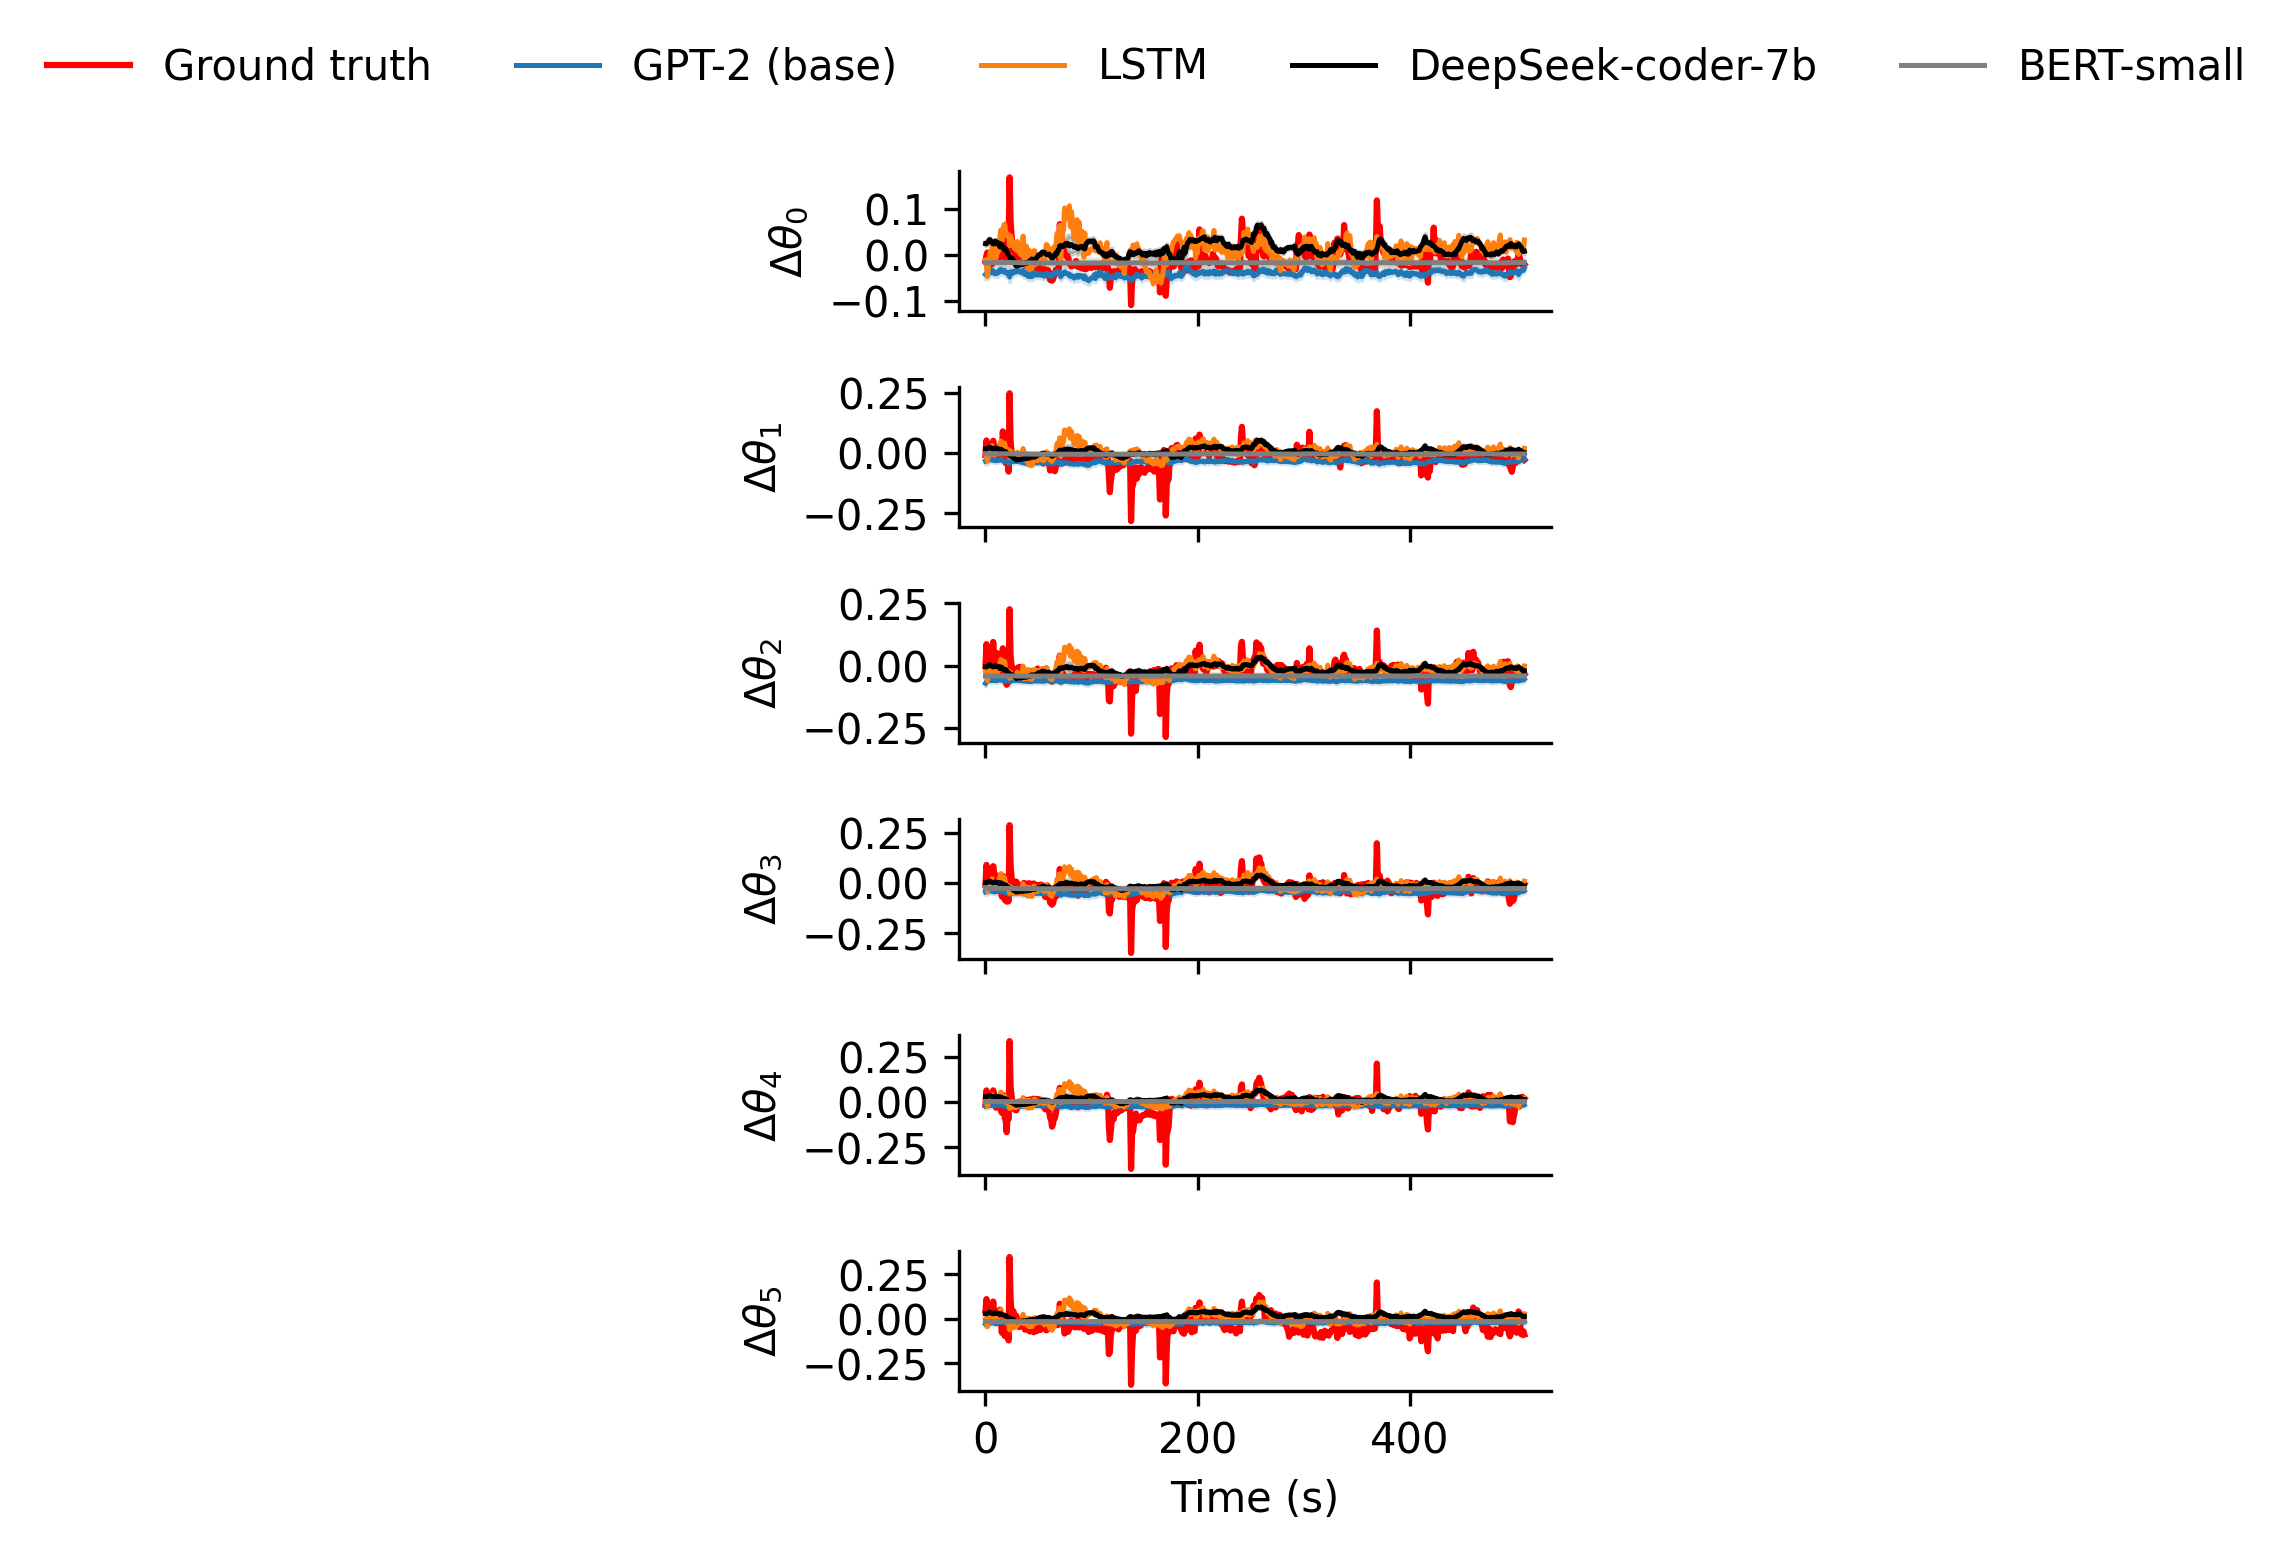

In [97]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# ─── CONFIG ───────────────────────────────────────────────────────────────────
fish             = 11
seq              = 10
use_components   = [0,1,2,3,4,5]
num_runs         = 10
models_to_use    = ["GPT-2 (base)", "LSTM", "DeepSeek-coder-7b", "BERT-small"]
panel_plot       = True                       # True = per-theta panels; False = summed-tail

# Figure size control
width            = 3.0    # total figure width (inches)
height_per_panel = 0.8    # height per subplot (inches)

# Time‐frame selection: None for full, or (start,end)
frame_range      = None

# ─── I/O & MODEL MAPPING ───────────────────────────────────────────────────────
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data","nlp4neuro","results_april30","experiment_1")
)
full_model_map = {
    "GPT-2 (base)"      : ("gpt2_pretrained", "#1f77b4"),
    "LSTM"              : ("lstm",            "#ff7f0e"),
    "DeepSeek-coder-7b" : ("deepseek_moe",    "#000000"),
    "BERT-small"        : ("bert",            "#7f7f7f"),
}
model_map = {m: full_model_map[m] for m in models_to_use}

# ─── LOAD & SLICE GROUND TRUTH ────────────────────────────────────────────────
gt_path  = os.path.join(
    RESULTS_ROOT, f"fish{fish}",
    f"fish{fish}_final_predictions_groundtruth_test.npy"
)
y_true   = np.load(gt_path)                    # shape (T,6)
time_vec = np.arange(y_true.shape[0]) / 1.1    # 1.1 Hz sampling

if frame_range is not None:
    start, end = frame_range
    y_true     = y_true[start:end]
    time_vec   = time_vec[start:end]

plt.rcParams["pdf.fonttype"] = 42

if panel_plot:
    # ─── PANEL VIEW ─────────────────────────────────────────────────────────
    # compute baseline per component from first 50 frames
    baselines = {comp: np.mean(y_true[:50, comp]) for comp in use_components}

    n = len(use_components)
    fig, axes = plt.subplots(
        n, 1, sharex=True,
        figsize=(width, height_per_panel * n),
        dpi=300
    )

    for idx, comp in enumerate(use_components):
        ax = axes[idx]
        # ground truth (shifted by baseline)
        gt_label = "Ground truth" if idx == 0 else None
        y_gt     = y_true[:, comp] - baselines[comp]
        ax.plot(time_vec, y_gt,
                color="red", lw=1.5, label=gt_label)

        # each model
        for model_name, (key, color) in model_map.items():
            runs = []
            for run in range(1, num_runs + 1):
                fpath = os.path.join(
                    RESULTS_ROOT,
                    f"fish{fish}", f"run_{run}",
                    f"seq_{seq}",
                    f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
                )
                if not os.path.isfile(fpath):
                    continue
                pred = np.load(fpath)
                if frame_range is not None:
                    pred = pred[start:end]
                runs.append(pred[:, comp] - baselines[comp])

            if not runs:
                continue

            data    = np.vstack(runs)
            mean_ts = data.mean(axis=0)
            sem_ts  = sem(data, axis=0)
            mlabel  = model_name if idx == 0 else None

            ax.plot(time_vec, mean_ts,
                    color=color, lw=1.2, label=mlabel)
            ax.fill_between(time_vec,
                            mean_ts - sem_ts,
                            mean_ts + sem_ts,
                            color=color, alpha=0.2)

        ax.set_ylabel(rf"$\Delta\theta_{{{comp}}}$")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # single-row legend above panels
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        ncol=len(handles),
        frameon=False,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.0),
        bbox_transform=fig.transFigure
    )
    fig.subplots_adjust(top=0.85)
    axes[-1].set_xlabel("Time (s)")
    fig.tight_layout()
    out_name = f"tail_panels_fish{fish}_s{seq}_baseline.pdf"

else:
    # ─── SUMMED-TAIL VIEW ─────────────────────────────────────────────────────
    # baseline from ground truth sum
    y_sum_full    = y_true[:, use_components].sum(axis=1)
    baseline_sum  = np.mean(y_sum_full[:50])
    y_sum_shifted = y_sum_full - baseline_sum

    fig, ax = plt.subplots(figsize=(width, height_per_panel), dpi=300)

    ax.plot(time_vec, y_sum_shifted,
            color="red", lw=1.5, label="Ground truth")

    for model_name, (key, color) in model_map.items():
        runs = []
        for run in range(1, num_runs + 1):
            fpath = os.path.join(
                RESULTS_ROOT,
                f"fish{fish}", f"run_{run}",
                f"seq_{seq}",
                f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
            )
            if not os.path.isfile(fpath):
                continue
            pred = np.load(fpath)
            if frame_range is not None:
                pred = pred[start:end]
            runs.append(pred[:, use_components].sum(axis=1) - baseline_sum)

        if not runs:
            continue

        data    = np.vstack(runs)
        mean_ts = data.mean(axis=0)
        sem_ts  = sem(data, axis=0)

        ax.plot(time_vec, mean_ts,
                color=color, lw=1.2, label=model_name)
        ax.fill_between(time_vec,
                        mean_ts - sem_ts,
                        mean_ts + sem_ts,
                        color=color, alpha=0.2)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta \sum_{i}\theta_i$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(ncol=1, frameon=False, loc="upper right")
    fig.tight_layout()
    out_name = f"tail_sum_fish{fish}_s{seq}_baseline.pdf"

# ─── SAVE ─────────────────────────────────────────────────────────────────────
out_file = os.path.join(RESULTS_ROOT, out_name)
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print("Saved to", out_file)


In [50]:
# print(y_true[:,5])

ff = np.load(f"{RESULTS_ROOT}/fish9/run_1/seq_20/fish9_final_predictions_deepseek_moe_test_run1.npy")
print(ff.shape)

(610, 6)


Saved to C:\Users\jacob\OneDrive\Documents\GitHub\external_data\nlp4neuro\results_april30\experiment_1\tail_panels_fish11_s10_baseline.pdf


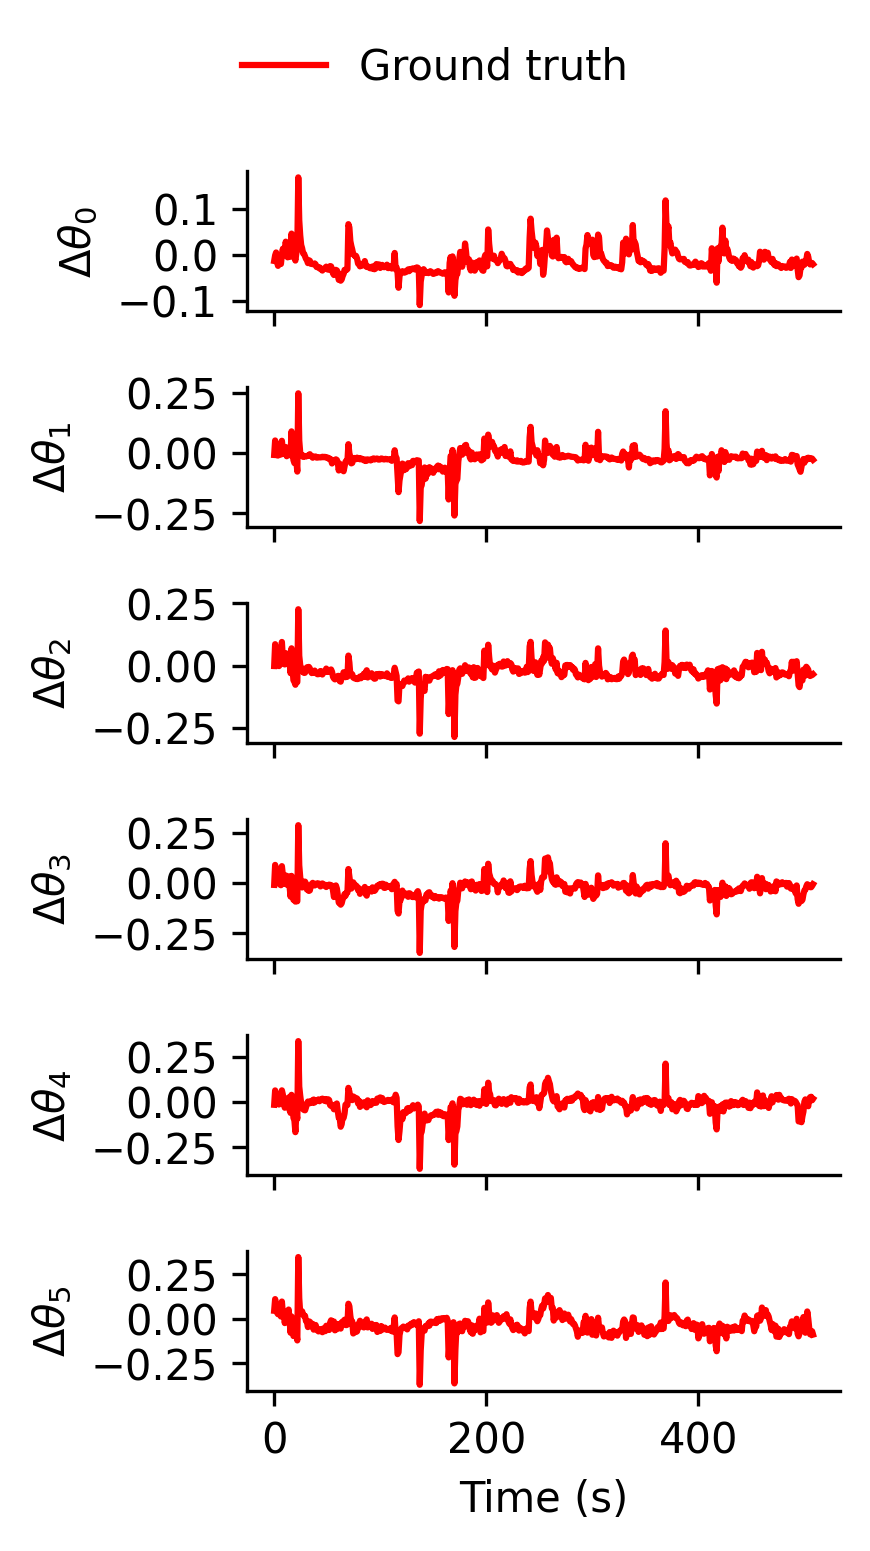

In [100]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

# ─── CONFIG ───────────────────────────────────────────────────────────────────
fish             = 11
seq              = 10
use_components   = [0,1,2,3,4,5]
num_runs         = 10
models_to_use    = []
panel_plot       = True                       # True = per-theta panels; False = summed-tail

# Figure size control
width            = 3.0    # total figure width (inches)
height_per_panel = 0.8    # height per subplot (inches)

# Time‐frame selection: None for full, or (start,end)
frame_range      = None

# ─── I/O & MODEL MAPPING ───────────────────────────────────────────────────────
RESULTS_ROOT = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir, os.pardir,
                 "external_data","nlp4neuro","results_april30","experiment_1")
)
full_model_map = {
    "GPT-2 (base)"      : ("gpt2_pretrained", "#1f77b4"),
    "LSTM"              : ("lstm",            "#ff7f0e"),
    "DeepSeek-coder-7b" : ("deepseek_moe",    "#000000"),
    "BERT-small"        : ("bert",            "#7f7f7f"),
}
model_map = {m: full_model_map[m] for m in models_to_use}

# ─── LOAD & SLICE GROUND TRUTH ────────────────────────────────────────────────
gt_path  = os.path.join(
    RESULTS_ROOT, f"fish{fish}",
    f"fish{fish}_final_predictions_groundtruth_test.npy"
)
y_true   = np.load(gt_path)                    # shape (T,6)
time_vec = np.arange(y_true.shape[0]) / 1.1    # 1.1 Hz sampling

if frame_range is not None:
    start, end = frame_range
    y_true     = y_true[start:end]
    time_vec   = time_vec[start:end]

plt.rcParams["pdf.fonttype"] = 42

if panel_plot:
    # ─── PANEL VIEW ─────────────────────────────────────────────────────────
    # compute baseline per component from first 50 frames
    baselines = {comp: np.mean(y_true[:50, comp]) for comp in use_components}

    n = len(use_components)
    fig, axes = plt.subplots(
        n, 1, sharex=True,
        figsize=(width, height_per_panel * n),
        dpi=300
    )

    for idx, comp in enumerate(use_components):
        ax = axes[idx]
        # ground truth (shifted by baseline)
        gt_label = "Ground truth" if idx == 0 else None
        y_gt     = y_true[:, comp] - baselines[comp]
        ax.plot(time_vec, y_gt,
                color="red", lw=1.5, label=gt_label)

        # each model
        for model_name, (key, color) in model_map.items():
            runs = []
            for run in range(1, num_runs + 1):
                fpath = os.path.join(
                    RESULTS_ROOT,
                    f"fish{fish}", f"run_{run}",
                    f"seq_{seq}",
                    f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
                )
                if not os.path.isfile(fpath):
                    continue
                pred = np.load(fpath)
                if frame_range is not None:
                    pred = pred[start:end]
                runs.append(pred[:, comp] - baselines[comp])

            if not runs:
                continue

            data    = np.vstack(runs)
            mean_ts = data.mean(axis=0)
            sem_ts  = sem(data, axis=0)
            mlabel  = model_name if idx == 0 else None

            ax.plot(time_vec, mean_ts,
                    color=color, lw=1.2, label=mlabel)
            ax.fill_between(time_vec,
                            mean_ts - sem_ts,
                            mean_ts + sem_ts,
                            color=color, alpha=0.2)

        ax.set_ylabel(rf"$\Delta\theta_{{{comp}}}$")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    # single-row legend above panels
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        ncol=len(handles),
        frameon=False,
        loc="lower center",
        bbox_to_anchor=(0.5, 1.0),
        bbox_transform=fig.transFigure
    )
    fig.subplots_adjust(top=0.85)
    axes[-1].set_xlabel("Time (s)")
    fig.tight_layout()
    out_name = f"tail_panels_fish{fish}_s{seq}_baseline.pdf"

else:
    # ─── SUMMED-TAIL VIEW ─────────────────────────────────────────────────────
    # baseline from ground truth sum
    y_sum_full    = y_true[:, use_components].sum(axis=1)
    baseline_sum  = np.mean(y_sum_full[:50])
    y_sum_shifted = y_sum_full - baseline_sum

    fig, ax = plt.subplots(figsize=(width, height_per_panel), dpi=300)

    ax.plot(time_vec, y_sum_shifted,
            color="red", lw=1.5, label="Ground truth")

    for model_name, (key, color) in model_map.items():
        runs = []
        for run in range(1, num_runs + 1):
            fpath = os.path.join(
                RESULTS_ROOT,
                f"fish{fish}", f"run_{run}",
                f"seq_{seq}",
                f"fish{fish}_final_predictions_{key}_test_run{run}.npy"
            )
            if not os.path.isfile(fpath):
                continue
            pred = np.load(fpath)
            if frame_range is not None:
                pred = pred[start:end]
            runs.append(pred[:, use_components].sum(axis=1) - baseline_sum)

        if not runs:
            continue

        data    = np.vstack(runs)
        mean_ts = data.mean(axis=0)
        sem_ts  = sem(data, axis=0)

        ax.plot(time_vec, mean_ts,
                color=color, lw=1.2, label=model_name)
        ax.fill_between(time_vec,
                        mean_ts - sem_ts,
                        mean_ts + sem_ts,
                        color=color, alpha=0.2)

    ax.set_xlabel("Time (s)")
    ax.set_ylabel(r"$\Delta \sum_{i}\theta_i$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(ncol=1, frameon=False, loc="upper right")
    fig.tight_layout()
    out_name = f"tail_sum_fish{fish}_s{seq}_baseline.pdf"

# ─── SAVE ─────────────────────────────────────────────────────────────────────
out_file = os.path.join(RESULTS_ROOT, out_name)
fig.savefig(out_file, dpi=300, bbox_inches="tight")
print("Saved to", out_file)
